**1. Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
!pip install hmmlearn
from hmmlearn import hmm
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('punkt')
nltk.download('stopwords')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 1.5 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**2. Loading the Dataset**

In [2]:
df = pd.read_csv('bbc-text.csv')
df.head()


,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


**3. Exploratory Data Analysis (EDA)**

       category                                               text
count      2225                                               2225
unique        5                                               2126
top       sport  kennedy questions trust of blair lib dem leade...
freq        511                                                  2
category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


<ipython-input-3-28e721353382>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='category', data=df, palette='viridis')


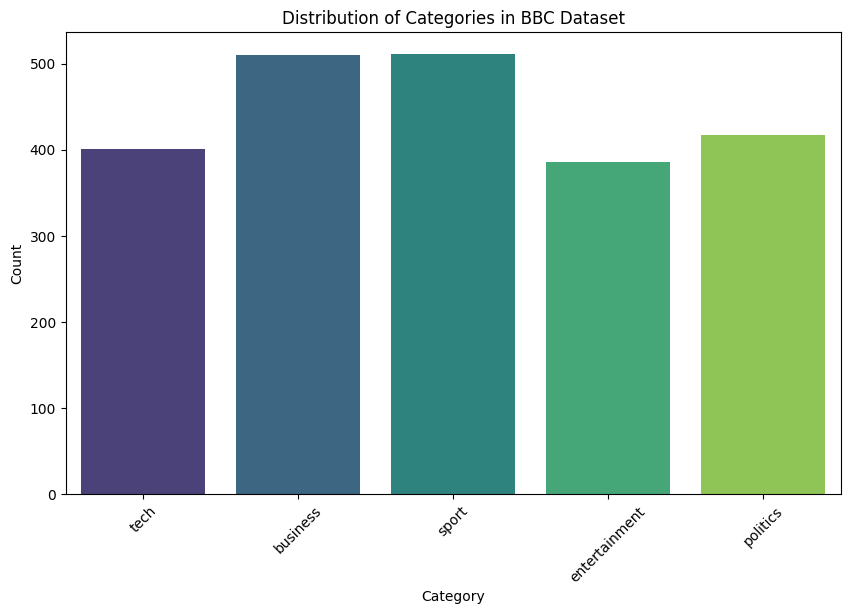

category    0
text        0
dtype: int64


In [3]:
print(df.describe())
print(df['category'].value_counts())

plt.figure(figsize=(10, 6))
sns.countplot(x='category', data=df, palette='viridis')
plt.title('Distribution of Categories in BBC Dataset')
plt.ylabel('Count')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.show()

print(df.isnull().sum())

**4. Data Preprocessing**

In [4]:
def clean_text(text):

    text = re.sub(r'\W', ' ', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    return text

def preprocess_text(text):

    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()

    words = nltk.word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    words = [stemmer.stem(word) for word in words]

    return ' '.join(words)

df['cleaned_text'] = df['text'].apply(preprocess_text)

X = df['cleaned_text']
y = df['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=5000)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


**5. Naive Bayes Model**

Naive Bayes Accuracy: 0.97
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       101
           1       1.00      0.91      0.95        81
           2       0.92      0.98      0.95        83
           3       0.99      1.00      0.99        98
           4       0.96      0.99      0.98        82

    accuracy                           0.97       445
   macro avg       0.97      0.97      0.97       445
weighted avg       0.97      0.97      0.97       445



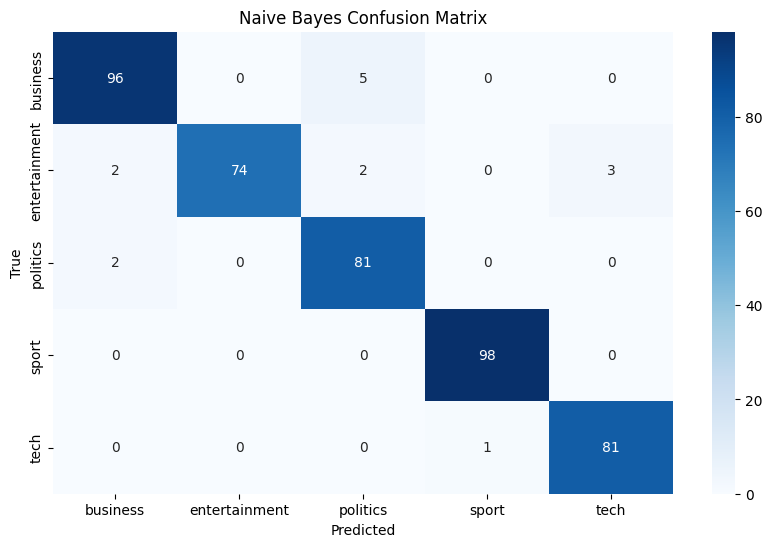

In [5]:
nb_model = MultinomialNB()
nb_model.fit(X_train_vect, y_train_encoded)
nb_predictions = nb_model.predict(X_test_vect)
print(f'Naive Bayes Accuracy: {accuracy_score(y_test_encoded, nb_predictions):.2f}')
print(classification_report(y_test_encoded, nb_predictions))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test_encoded, nb_predictions), annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


**6. Support Vector Machine (SVM)**

Initial SVM Accuracy: 0.97
Best parameters after Grid Search: {'C': 1, 'kernel': 'linear'}
SVM Accuracy after Grid Search: 0.97
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       101
           1       0.98      0.98      0.98        81
           2       0.94      0.96      0.95        83
           3       0.98      1.00      0.99        98
           4       0.99      0.98      0.98        82

    accuracy                           0.97       445
   macro avg       0.97      0.97      0.97       445
weighted avg       0.97      0.97      0.97       445



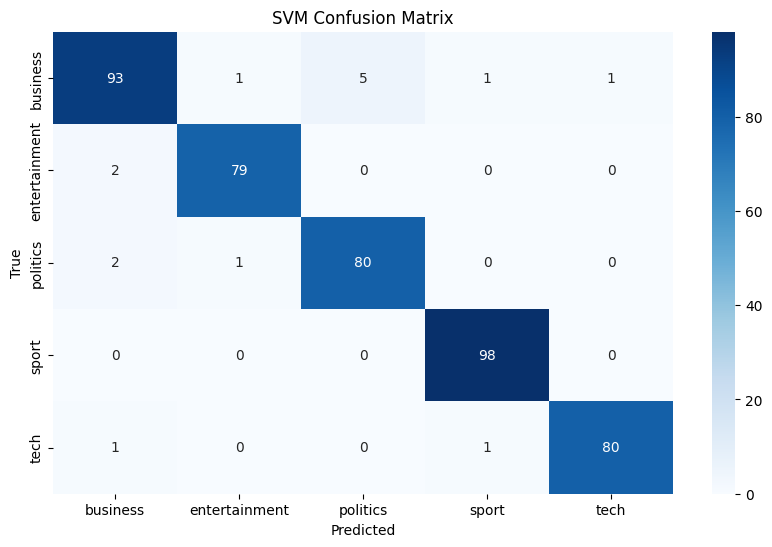

In [6]:
svm_model = SVC()
svm_model.fit(X_train_vect, y_train_encoded)

initial_svm_predictions = svm_model.predict(X_test_vect)
print(f'Initial SVM Accuracy: {accuracy_score(y_test_encoded, initial_svm_predictions):.2f}')

param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10]
}
svm_grid = GridSearchCV(svm_model, param_grid, cv=5)
svm_grid.fit(X_train_vect, y_train_encoded)
svm_model = svm_grid.best_estimator_
print(f"Best parameters after Grid Search: {svm_grid.best_params_}")

svm_predictions = svm_model.predict(X_test_vect)
print(f'SVM Accuracy after Grid Search: {accuracy_score(y_test_encoded, svm_predictions):.2f}')
print(classification_report(y_test_encoded, svm_predictions))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test_encoded, svm_predictions), annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



**7. Random Forest Model**

Initial Random Forest Accuracy: 0.95
Best parameters after Grid Search: {'max_depth': None, 'n_estimators': 100}
Random Forest Accuracy after Grid Search: 0.95
              precision    recall  f1-score   support

           0       0.91      0.94      0.93       101
           1       0.99      0.94      0.96        81
           2       0.94      0.94      0.94        83
           3       0.97      0.98      0.97        98
           4       0.96      0.96      0.96        82

    accuracy                           0.95       445
   macro avg       0.95      0.95      0.95       445
weighted avg       0.95      0.95      0.95       445



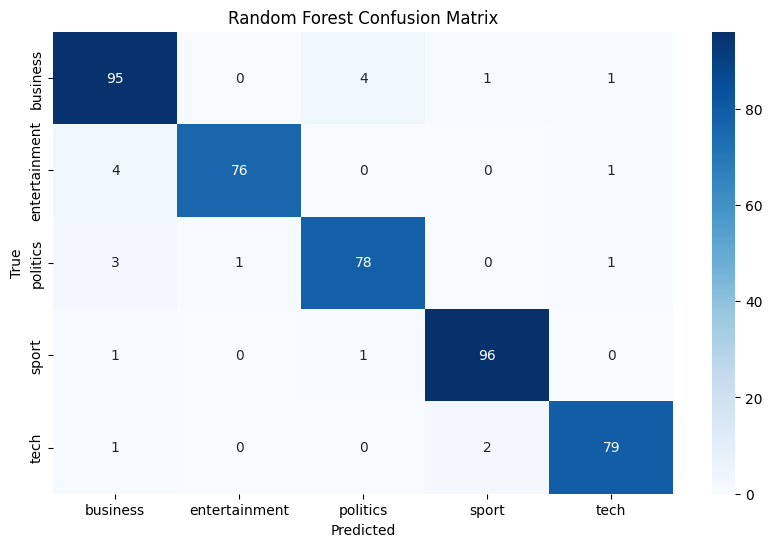

In [7]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_vect, y_train_encoded)

initial_rf_predictions = rf_model.predict(X_test_vect)
print(f'Initial Random Forest Accuracy: {accuracy_score(y_test_encoded, initial_rf_predictions):.2f}')

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20]
}
rf_grid = GridSearchCV(rf_model, param_grid, cv=5)
rf_grid.fit(X_train_vect, y_train_encoded)
rf_model = rf_grid.best_estimator_
print(f"Best parameters after Grid Search: {rf_grid.best_params_}")

rf_predictions = rf_model.predict(X_test_vect)
print(f'Random Forest Accuracy after Grid Search: {accuracy_score(y_test_encoded, rf_predictions):.2f}')
print(classification_report(y_test_encoded, rf_predictions))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test_encoded, rf_predictions), annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**8. Hidden Markov Model (HMM)**

HMM Model Accuracy:, 0.71
HMM Model Classification Report:
                precision    recall  f1-score   support

     business       0.81      0.77      0.79       102
entertainment       0.76      0.36      0.49        77
     politics       0.57      0.85      0.68        84
        sport       0.67      0.78      0.72       102
         tech       0.89      0.74      0.81        80

     accuracy                           0.71       445
    macro avg       0.74      0.70      0.70       445
 weighted avg       0.74      0.71      0.71       445



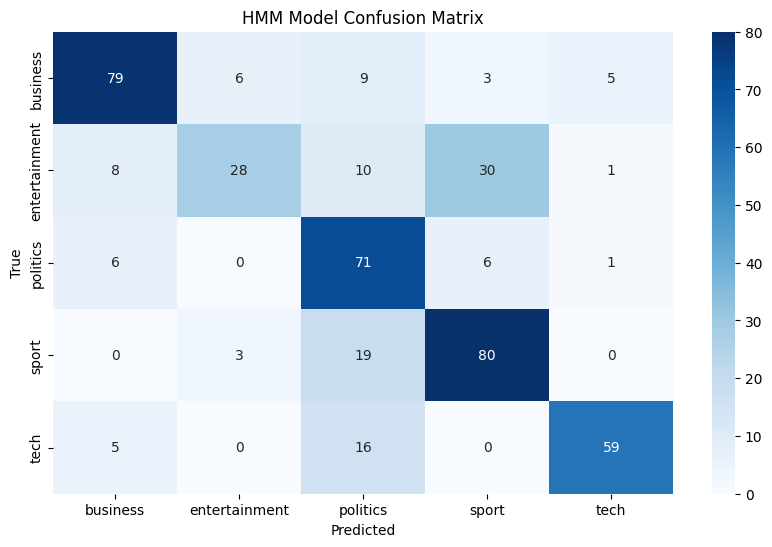

In [8]:
import pandas as pd
import re
import numpy as np
from gensim.models import Word2Vec
from hmmlearn import hmm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

np.random.seed(42)

data = pd.read_csv('bbc-text.csv')

df_duplicate = data.copy()

def independent_preprocess_text(df):
    def preprocess_text(text):
        if isinstance(text, list):
            text = " ".join(text)
        text = re.sub(r'[^\w\s]', '', text.lower())
        return text.split()

    df['cleaned_text'] = df['text'].apply(preprocess_text)
    return df

df_duplicate = independent_preprocess_text(df_duplicate)

label_encoder = LabelEncoder()
df_duplicate['category_encoded'] = label_encoder.fit_transform(df_duplicate['category'])

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_duplicate['cleaned_text'], df_duplicate['category_encoded'],
    test_size=0.2, random_state=42,
    stratify=df_duplicate['category_encoded']
)
def hmm_train_and_evaluate(train_texts, train_labels, test_texts, label_encoder):

    hmm_w2v_model = Word2Vec(sentences=train_texts.tolist(), vector_size=100, window=5, min_count=2, workers=1, seed=42)

    def hmm_sentence_embedding(sentence, model):
        embedding = np.array([model.wv[word] for word in sentence if word in model.wv])
        return np.mean(embedding, axis=0) if len(embedding) > 0 else np.zeros(100)

    hmm_train_embeddings = np.array([hmm_sentence_embedding(sentence, hmm_w2v_model) for sentence in train_texts])
    hmm_test_embeddings = np.array([hmm_sentence_embedding(sentence, hmm_w2v_model) for sentence in test_texts])

    unique_labels = np.unique(train_labels)
    hmm_models = {}

    for label in unique_labels:
        model = hmm.GaussianHMM(n_components=3, covariance_type='diag', n_iter=500, random_state=42)
        class_data = np.array([hmm_train_embeddings[i] for i in range(len(train_labels)) if train_labels.iloc[i] == label])

        if class_data.shape[0] > 0:
            model.fit(class_data)
            hmm_models[label] = model

    def predict_hmm(hmm_models, X, default_label=0):
        preds = []
        for x in X:
            scores = {}
            for label, model in hmm_models.items():
                try:
                    score = model.score([x.reshape(-1)])
                    scores[label] = score
                except Exception as e:
                    print(f"Error scoring for label {label}: {e}")
            preds.append(max(scores, key=scores.get) if scores else default_label)
        return preds

    most_frequent_label = np.bincount(train_labels).argmax()
    y_pred_hmm = predict_hmm(hmm_models, hmm_test_embeddings, default_label=most_frequent_label)

    print(f'HMM Model Accuracy:, {accuracy_score(test_labels, y_pred_hmm):.2f}')
    print("HMM Model Classification Report:\n", classification_report(test_labels, y_pred_hmm, target_names=label_encoder.classes_))

    plt.figure(figsize=(10, 6))
    sns.heatmap(confusion_matrix(test_labels, y_pred_hmm), annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('HMM Model Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    return hmm_models, hmm_w2v_model, y_pred_hmm
hmm_models, hmm_w2v_model,y_pred_hmm = hmm_train_and_evaluate(train_texts, train_labels, test_texts, label_encoder)

**9. Ensemble Learning (Voting Classifier)**

Voting Classifier Accuracy: 0.96
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       101
           1       0.99      0.95      0.97        81
           2       0.94      0.96      0.95        83
           3       0.98      1.00      0.99        98
           4       0.99      0.98      0.98        82

    accuracy                           0.96       445
   macro avg       0.97      0.96      0.96       445
weighted avg       0.96      0.96      0.96       445



<function matplotlib.pyplot.title(label, fontdict=None, loc=None, pad=None, *, y=None, **kwargs)>

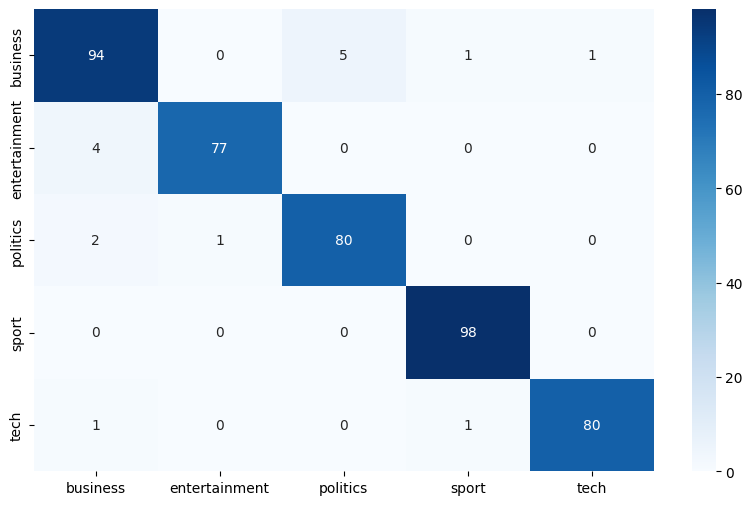

In [9]:
voting_model = VotingClassifier(estimators=[
    ('nb', nb_model),
    ('svm', svm_model),
    ('rf', rf_model)],
    voting='hard')
voting_model.fit(X_train_vect, y_train_encoded)
voting_predictions = voting_model.predict(X_test_vect)
print(f'Voting Classifier Accuracy: {accuracy_score(y_test_encoded, voting_predictions):.2f}')
print(classification_report(y_test_encoded, voting_predictions))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test_encoded, voting_predictions), annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title

**10. Model Camparison**

<ipython-input-10-d2c8b2e5f3c4>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=model_comparison_df, palette='viridis')


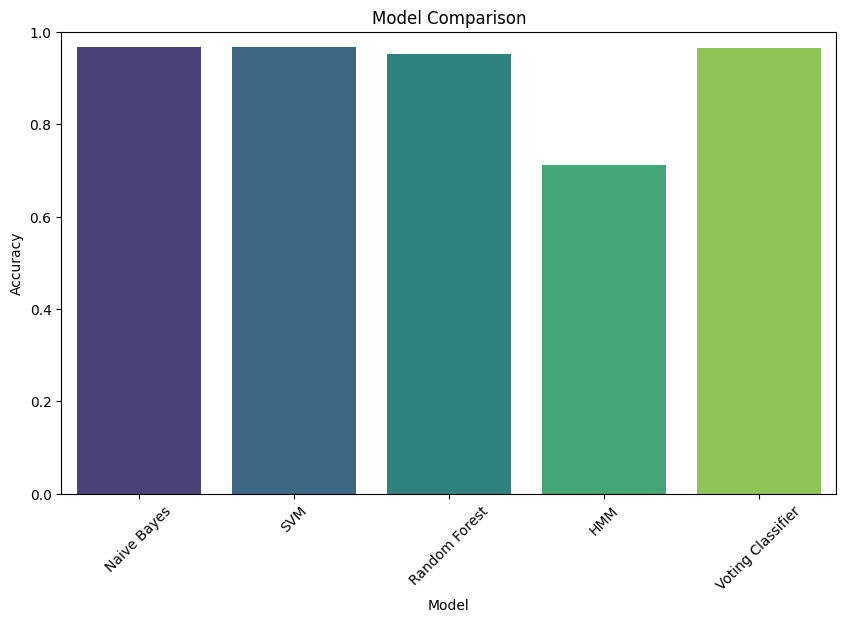


Model Performance Summary:
Naive Bayes: 0.97
SVM: 0.97
Random Forest: 0.95
HMM: 0.71
Voting Classifier: 0.96


In [10]:
model_accuracies = {
     "Naive Bayes": accuracy_score(y_test_encoded, nb_predictions),
    "SVM": accuracy_score(y_test_encoded, svm_predictions),
    "Random Forest": accuracy_score(y_test_encoded, rf_predictions),
    "HMM": accuracy_score(test_labels, y_pred_hmm),
    "Voting Classifier": accuracy_score(y_test_encoded, voting_predictions)
}

model_comparison_df = pd.DataFrame(list(model_accuracies.items()), columns=['Model', 'Accuracy'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=model_comparison_df, palette='viridis')
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

print("\nModel Performance Summary:")
for model, accuracy in model_accuracies.items():
    print(f"{model}: {accuracy:.2f}")


In [11]:
def user_interaction(nb_model, svm_model, rf_model, hmm_models, voting_model, vectorizer, label_encoder, hmm_w2v_model):
    def hmm_sentence_embedding(sentence, model):
        embedding = np.array([model.wv[word] for word in sentence if word in model.wv])
        return np.mean(embedding, axis=0) if len(embedding) > 0 else np.zeros(100)

    while True:
        user_input = input("Enter a news headline (or type 'exit' to quit): ")

        if user_input.lower() == 'exit':
            break

        processed_input = preprocess_text(user_input)
        user_input_tfidf = vectorizer.transform([processed_input])

        nb_prediction = nb_model.predict(user_input_tfidf)
        nb_category = label_encoder.inverse_transform(nb_prediction)[0]

        svm_prediction = svm_model.predict(user_input_tfidf)
        svm_category = label_encoder.inverse_transform(svm_prediction)[0]

        rf_prediction = rf_model.predict(user_input_tfidf)
        rf_category = label_encoder.inverse_transform(rf_prediction)[0]

        hmm_input_embedding = hmm_sentence_embedding(processed_input.split(), hmm_w2v_model).reshape(1, -1)

        scores = {}
        for label, model in hmm_models.items():
            try:
                score = model.score(hmm_input_embedding)
                scores[label] = score
            except Exception as e:
                print(f"Error scoring for label {label}: {e}")

        if scores:
            hmm_prediction = max(scores, key=scores.get)
            hmm_category = label_encoder.inverse_transform([hmm_prediction])[0]
        else:
            hmm_category = "Unknown"

        voting_prediction = voting_model.predict(user_input_tfidf)
        voting_category = label_encoder.inverse_transform(voting_prediction)[0]


        print(f"\nPredicted Category (Naive Bayes): {nb_category}")
        print(f"Predicted Category (SVM): {svm_category}")
        print(f"Predicted Category (Random Forest): {rf_category}")
        print(f"Predicted Category (HMM): {hmm_category}")
        print(f"Predicted Category (Voting Classifier): {voting_category}\n")

        feedback = input("Do you want to test another headline? (yes/no): ")
        if feedback.lower() != 'yes':
            break

user_interaction(nb_model, svm_model, rf_model, hmm_models, voting_model, vectorizer, label_encoder, hmm_w2v_model)

Enter a news headline (or type 'exit' to quit): tv future in the hands of viewers with home theatre systems plasma high-definition tvs and digital video recorders moving into the living room the way people watch tv will be radically different in five years time. that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend programmes and other content will be delivered to viewers via home networks through cable satellite telecoms companies and broadband service providers to front rooms and portable devices. one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes like the us s tivo and the uk s sky+ system allow people to record store play pause and forward wind tv programmes when they want. essentially the technology allows for much more personalised tv. they ar